In [1]:
import sys

In [2]:
sys.path.append('/home/bh774267/.local/lib/python3.11/site-packages')

In [3]:
!pip install --user biopython

  Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (3.2 MB)


In [3]:
print("hello")

hello


In [4]:
import os
import re
import requests
import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from Bio.PDB import PDBList

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
SCOPE_VERSION = "2.07"
#CLA_URL = f"https://scop.berkeley.edu/downloads/parse/dir.cla.scope.{SCOPE_VERSION}-stable.txt"
cla_url = f"http://scop.berkeley.edu/downloads/parse/dir.cla.scope.{SCOPE_VERSION}-stable.txt"
cla_text = requests.get(cla_url, verify=False).text

domain_rows = []
pattern = re.compile(r"([A-Z]):(\d+)-(\d+)")

for line in cla_text.splitlines():
    if line.startswith("#") or not line.strip():
        continue
    parts = line.split()
    if len(parts) < 5:
        continue
    
    domain_id = parts[0]
    pdb_id = parts[1][:4].lower()
    chain_region = parts[2]       # Example: "A:16-88,A:110-185"
    fold_id = parts[3]

    segments = []
    for seg in chain_region.split(','):
        m = pattern.match(seg)
        if m:
            chain_id = m.group(1)
            start = int(m.group(2))
            end = int(m.group(3))
            segments.append((chain_id, start, end))

    if len(segments) > 0:
        domain_rows.append([domain_id, pdb_id, segments, fold_id])

df_domains = pd.DataFrame(domain_rows, columns=["domain", "pdb_id", "segments", "fold_id"])
print("Parsed SCOPe domains:", len(df_domains))


Parsed SCOPe domains: 132757


In [6]:
df_domains
df_domains_subset = df_domains.sample(n=5000, random_state=42)

In [7]:
pdbl = PDBList()
pdb_dir = "pdb_files"
os.makedirs(pdb_dir, exist_ok=True)

def download_pdb(pdb_id):
    path = os.path.join(pdb_dir, f"{pdb_id}.pdb")
    if os.path.exists(path):
        return path
    try:
        pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format='pdb')
    except:
        # try RCSB direct
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        r = requests.get(url)
        if r.status_code == 200:
            with open(path, "w") as f:
                f.write(r.text)
    return path


In [8]:
def extract_domain_ca(pdb_path, segments):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    model = structure[0]

    coords = []
    for chain_id, start, end in segments:
        if chain_id not in model:
            continue
        chain = model[chain_id]
        for res in chain:
            resnum = res.id[1]
            if start <= resnum <= end:
                if "CA" in res:
                    coords.append(res["CA"].coord)

    if len(coords) < 10:
        return None

    return np.stack(coords)


In [9]:
def compute_distance_matrix(coords):
    diff = coords[:, None, :] - coords[None, :, :]
    return np.sqrt((diff ** 2).sum(-1))

In [9]:
"""
def crop_matrix(D, window=100):
    crops = []
    N = D.shape[0]
    for i in range(0, N, window):
        for j in range(0, N, window):
            crop = D[i:i+window, j:j+window]
            if crop.shape == (window, window):
                crops.append(crop)
    return crops
"""

In [10]:
"""
import numpy as np

def generate_crops(coords, crop_size=120, stride=20, max_dist=20.0):
    
    Creates overlapping cropped distance matrices (PRO3DCNN style).

    coords : np.array of shape (N,3)  (Cα coordinates)
    crop_size : size of each square crop (default 120)
    stride : step size for sliding window
    max_dist : clipping threshold for normalization
    

    # Step 1: compute full NxN distance matrix
    N = coords.shape[0]
    if N < crop_size:
        return []     # too small to crop

    # Full DM
    diff = coords[:, None, :] - coords[None, :, :]
    DM = np.sqrt((diff ** 2).sum(axis=2))

    # Normalize like PRO3DCNN (clip + scale)
    DM = np.clip(DM, 0, max_dist) / max_dist

    crops = []

    # Step 2: sliding window
    for i in range(0, N - crop_size + 1, stride):
        for j in range(0, N - crop_size + 1, stride):
            crop = DM[i:i+crop_size, j:j+crop_size]

            # Some safety checks
            if crop.size == 0:
                continue
            if np.all(crop == 0):
                continue

            crops.append(crop.astype(np.float32))

    return crops
"""

In [10]:
class Conv3DBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=k, padding=p)
        self.bn   = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class Residual3DBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = Conv3DBlock(ch, ch)
        self.conv2 = Conv3DBlock(ch, ch)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))


class PRO3DNet(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()

        self.block0 = Conv3DBlock(1, 32)   

        self.block1 = nn.Sequential(
            Conv3DBlock(32, 64),
            Residual3DBlock(64),
            nn.MaxPool3d(2)    
        )

        self.block2 = nn.Sequential(
            Conv3DBlock(64, 128),
            Residual3DBlock(128),
            Residual3DBlock(128),
            nn.MaxPool3d(2)    
        )

        self.block3 = nn.Sequential(
            Conv3DBlock(128, 256),
            Residual3DBlock(256),
            Residual3DBlock(256),
            nn.MaxPool3d(2)   
        )

        self.bottleneck = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )

        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x: (B, 1, 48, 48, 48)
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.bottleneck(x)

        x = F.adaptive_avg_pool3d(x, 1).view(x.size(0), -1)  # (B, 256)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [11]:
le = LabelEncoder()
df_domains["label"] = le.fit_transform(df_domains["fold_id"])

In [ ]:
import multiprocessing as mp

def process_row(row):
    pdb_path = download_pdb(row["pdb_id"])
    if pdb_path is None:
        return None

    try:
        coords = extract_domain_ca(pdb_path, row["segments"])
        if coords is None: return None
        if coords.shape[0] < 50: return None
    except:
        return None

    row_out = row.copy()
    row_out["ca_coords"] = coords
    return row_out

rows = df_domains.to_dict("records")

with mp.Pool(processes=12) as pool:
    results = list(pool.map(process_row, rows))

df_valid = pd.DataFrame([r for r in results if r is not None])
print("Valid domains:", len(df_valid))


Structure exists: 'pdb_files/pdb1ikn.ent' 
Structure exists: 'pdb_files/pdb2ram.ent' 
Structure exists: 'pdb_files/pdb2ram.ent' 
Structure exists: 'pdb_files/pdb1ram.ent' 
Structure exists: 'pdb_files/pdb1ram.ent' 
Structure exists: 'pdb_files/pdb1vkx.ent' 
Structure exists: 'pdb_files/pdb1s9k.ent' 
Structure exists: 'pdb_files/pdb1p7h.ent' 
Structure exists: 'pdb_files/pdb1p7h.ent' 
Structure exists: 'pdb_files/pdb1p7h.ent' 
Structure exists: 'pdb_files/pdb1p7h.ent' 
Structure exists: 'pdb_files/pdb3do7.ent' 
Structure exists: 'pdb_files/pdb3do7.ent' 
Structure exists: 'pdb_files/pdb1ttu.ent' 
Structure exists: 'pdb_files/pdb3brf.ent' 
Structure exists: 'pdb_files/pdb1e2w.ent' 
Structure exists: 'pdb_files/pdb1e2w.ent' 
Structure exists: 'pdb_files/pdb1e2v.ent' 
Structure exists: 'pdb_files/pdb1e2v.ent' 
Structure exists: 'pdb_files/pdb1e2v.ent' 
Structure exists: 'pdb_files/pdb1cfm.ent' 
Structure exists: 'pdb_files/pdb1cfm.ent' 
Structure exists: 'pdb_files/pdb1cfm.ent' 
Structure e

In [14]:
from sklearn.preprocessing import LabelEncoder

# 1. Filter classes based on original fold_id
fold_counts = df_valid["fold_id"].value_counts()
good_folds = fold_counts[fold_counts >= 2].index

df_final = df_valid[df_valid["fold_id"].isin(good_folds)].copy()

print("After filtering by fold_id:")
print("  Num unique folds:", df_final["fold_id"].nunique())
print("  Min samples per fold:", df_final["fold_id"].value_counts().min())
print("  Total domains:", len(df_final))

df_final["main_class"] = df_final["fold_id"].str[0]

le = LabelEncoder()
df_final["label"] = le.fit_transform(df_final["main_class"])

print("\nAfter encoding labels:")
print("  Num classes:", df_final["main_class"].nunique())
print("  main_class min:", df_final["main_class"].min())
print("  main_class max:", df_final["main_class"].max())

print("\nAfter encoding labels:")
print("  Num classes:", df_final["label"].nunique())
print("  Label min:", df_final["label"].min())
print("  Label max:", df_final["label"].max())


After filtering by fold_id:
  Num unique folds: 1106
  Min samples per fold: 2
  Total domains: 10675

After encoding labels:
  Num classes: 10
  main_class min: a
  main_class max: j

After encoding labels:
  Num classes: 10
  Label min: 0
  Label max: 9


In [15]:
print(df_final.columns)

Index(['domain', 'pdb_id', 'segments', 'fold_id', 'label', 'ca_coords',
       'main_class'],
      dtype='object')


In [20]:
"""
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_valid["label"] = le.fit_transform(df_valid["fold_id"])

counts = df_valid["label"].value_counts()
good_labels = counts[counts >= 2].index

df_final = df_valid[df_valid["label"].isin(good_labels)].copy()

print("Num classes after filtering:", df_final["label"].nunique())
print("Min samples per class:", df_final["label"].value_counts().min())
print("Total domains:", len(df_final))
print(df_final[["fold_id", "label"]].head())
print("Num classes:", df_final["label"].nunique())
"""

Num classes after filtering: 733
Min samples per class: 2
Total domains: 5053
     fold_id  label
0    f.1.4.1   1245
1  d.218.1.2   1046
3  d.129.3.0    935
4   a.29.2.0    154
5   a.45.1.0    242
Num classes: 733


In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def voxelize_ca(coords, grid_size=48, sigma=2.0, resolution=2.0):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    coords = np.array(coords)
    coords_centered = coords - coords.mean(axis=0)
    grid_center_idx = grid_size / 2.0
    coords_mapped = (coords_centered / resolution) + grid_center_idx

    for x, y, z in coords_mapped:
        xi, yi, zi = int(round(x)), int(round(y)), int(round(z))
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                for dz in range(-1, 2):
                    x_idx = xi + dx
                    y_idx = yi + dy
                    z_idx = zi + dz
                    if 0 <= x_idx < grid_size and 0 <= y_idx < grid_size and 0 <= z_idx < grid_size:
                        w = np.exp(-(dx**2 + dy**2 + dz**2) / (2 * sigma**2))
                        grid[x_idx, y_idx, z_idx] += w

    if grid.max() > 0:
        grid /= grid.max()
    return grid

class ProteinDataset(Dataset):
    def __init__(self, df, grid_size=48):
        self.df = df.reset_index(drop=True)
        self.grid_size = grid_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        coords = self.df.iloc[idx]["ca_coords"]
        x = voxelize_ca(coords, grid_size=self.grid_size)  # (G,G,G)
        y = self.df.iloc[idx]["label"]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # (1,G,G,G)
        y = torch.tensor(y, dtype=torch.long)
        return x, y


In [15]:
"""
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_valid["fold_id"])

crop_dir = "crops"
os.makedirs(crop_dir, exist_ok=True)

all_entries = []

for idx, row in df_valid.iterrows():
    coords = row["ca_coords"]
    crops = generate_crops(coords, crop_size=100, stride=50)

    if len(crops) == 0:
        continue  # Skip domains that generated no crops
    
    crop_paths = []
    for i, crop in enumerate(crops):
        p = f"{crop_dir}/{row['domain']}_{i}.npy"
        np.save(p, crop)
        crop_paths.append(p)
    label_encoded = le.transform([row["fold_id"]])[0]
    all_entries.append({
        "domain": row["domain"],
        "fold_id": row["fold_id"],
        "label": label_encoded,
        "crops": crop_paths
    })

df_crops = pd.DataFrame(all_entries)
#df_crops.to_pickle("dataset_with_crops.pkl")

print("Saved precomputed crops:", len(df_crops))
"""

Saved precomputed crops: 4309


In [16]:
"""
class DistMCropDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        crop_paths = row["crops"]
        if len(crop_paths) == 0:
            return None  # Safety check

        x = torch.stack([torch.tensor(np.load(p)).unsqueeze(0) for p in crop_paths])
        y = torch.tensor(row["label"])
        return x, y
"""

In [17]:
from sklearn.model_selection import train_test_split

#df_final = df_valid.copy()  # has ca_coords + label
train_df, test_df = train_test_split(
    df_final,
    test_size=0.2,
    stratify=df_final["label"],
    random_state=42
)

train_ds = ProteinDataset(train_df, grid_size=48)
test_ds  = ProteinDataset(test_df, grid_size=48)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=4)


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
"""
from collections import Counter

df_final = df_crops.copy()

# Optional: filter classes with >= 2 samples
counts = df_final["label"].value_counts()
good_classes = counts[counts >= 2].index
df_final = df_final[df_final["label"].isin(good_classes)].copy()

print("Final domains ready for splitting:", len(df_final))

le = LabelEncoder()
df_final["label"] = le.fit_transform(df_final["fold_id"])

num_classes = df_final["label"].nunique()
print("Num classes:", num_classes)
print("Label min/max after re-encoding:", df_final["label"].min(), df_final["label"].max())
"""

Final domains ready for splitting: 3868
Num classes: 551
Label min/max after re-encoding: 0 550


In [54]:
"""
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    x, y = zip(*batch)
    return torch.stack(x), torch.tensor(y)
    """

SyntaxError: incomplete input (3968516296.py, line 1)

In [19]:
"""
import torch

def custom_collate_fn(batch):
    # 1. Filter out any 'None' values
    batch = [item for item in batch if item is not None]
    
    if len(batch) == 0:
        return None 

    # 2. Separate crops (X) and labels (Y)
    crops_list, labels_list = zip(*batch)

    # 3. Handle Labels (Y)
    # Labels are single items and can be safely stacked.
    y_batch = torch.stack(labels_list) 

    # 4. Find the max number of crops in this specific batch (N_max)
    max_crops = max(c.shape[0] for c in crops_list)

    # 5. Pad the Crops (X)
    padded_crops = []
    for crops_tensor in crops_list:
        num_crops = crops_tensor.shape[0]
        padding_needed = max_crops - num_crops
        
        if padding_needed > 0:
            # Create a tensor of zeros for padding. Shape: (padding_needed, 1, 100, 100)
            padding_tensor = torch.zeros(
                padding_needed, 
                1, # 1
                100, # 100
                100, # 100
                dtype=crops_tensor.dtype
            )
            # Concatenate the original crops with the padding zeros
            padded_crops.append(torch.cat((crops_tensor, padding_tensor), dim=0))
        else:
            # No padding needed, use the tensor as is
            padded_crops.append(crops_tensor)

    # 6. Stack the padded crops to create the final batch tensor
    # Output shape: (Batch Size, Max Crops in Batch, 1, 100, 100)
    x_batch = torch.stack(padded_crops)

    return x_batch, y_batch
"""

In [20]:
"""
train_df, test_df = train_test_split(
    df_final,
    test_size=0.2,
    stratify=df_final["label"],
    random_state=42
)
"""

In [18]:
print("Train labels min/max:", train_df["label"].min(), train_df["label"].max())
print("Test labels min/max:", test_df["label"].min(), test_df["label"].max())

Train labels min/max: 0 9
Test labels min/max: 0 9


In [65]:
#train_ds = DistMCropDataset(train_df)
#test_ds  = DistMCropDataset(test_df)

#train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
#test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False)

In [66]:


"""
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers = 4
)
"""

'\ntrain_loader = DataLoader(\n    train_ds,\n    batch_size=8,\n    shuffle=True,\n    collate_fn=custom_collate_fn,\n    num_workers = 4\n)\n'

In [48]:
"""
test_loader = DataLoader(
    test_ds,
    batch_size=8,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=4
)
"""

In [24]:
device = "cpu"  # debug first

for batch in train_loader:
    if batch is None:
        continue
    features, labels = batch
    print("Batch crops shape:", features.shape)
    print("Crops dtype:", features.dtype)
    print("Crops min/max:", features.min().item(), features.max().item())
    print("Label min/max:", labels.min().item(), labels.max().item())
    break


Batch crops shape: torch.Size([8, 1, 48, 48, 48])
Crops dtype: torch.float32
Crops min/max: 0.0 1.0
Label min/max: 21 1193


In [17]:
num_classes = df_final["label"].nunique()
print("Num classes:", num_classes)

Num classes: 10


In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PRO3DNet(num_classes=num_classes).to(device)
"""
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
"""

'\noptimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9, weight_decay=1e-4)\ncriterion = nn.CrossEntropyLoss()\n'

In [40]:
# 1. Force CPU mode for debugging
device = "cpu"

# 2. Move model and criterion to CPU
model =  PRO3DNet(num_classes=num_classes).to(device)
criterion = criterion.to(device)  # safe even if it was already on CPU

# 3. Get a single batch
features, labels = next(iter(train_loader))  # or train_loader1, whichever you're using
features = features.to(device)
labels = labels.to(device)

print("features shape:", features.shape)
print("labels shape:", labels.shape)
print("labels dtype:", labels.dtype)
print("labels min/max:", labels.min().item(), labels.max().item())
print("num_classes:", num_classes)

# 4. Forward + loss on CPU
outputs = model(features)
print("outputs shape:", outputs.shape)

loss = criterion(outputs, labels)
loss.backward()  # Now if labels are invalid, you'll get a clear Python error


features shape: torch.Size([8, 1, 48, 48, 48])
labels shape: torch.Size([8])
labels dtype: torch.int64
labels min/max: 101 673
num_classes: 733
outputs shape: torch.Size([8, 733])


In [42]:
print("Num Classes", num_classes)
for epoch in range(20):
    model.train()
    total_loss = 0

    for batch in train_loader:
        if batch is None:
            continue
        crops, label = batch
        #print("Batch crops shape:", crops.shape)
        #print("Label min/max:", label.min().item(), label.max().item())
        #break 
        crops = crops.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(crops)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

Num Classes 551
Epoch 1 Loss: 5.8932
Epoch 2 Loss: 5.3852
Epoch 3 Loss: 5.2063
Epoch 4 Loss: 5.0549
Epoch 5 Loss: 4.8867
Epoch 6 Loss: 4.7597
Epoch 7 Loss: 4.6723
Epoch 8 Loss: 4.6012
Epoch 9 Loss: 4.5002
Epoch 10 Loss: 4.4534
Epoch 11 Loss: 4.4271
Epoch 12 Loss: 4.3691
Epoch 13 Loss: 4.3175
Epoch 14 Loss: 4.2644
Epoch 15 Loss: 4.2477
Epoch 16 Loss: 4.1975
Epoch 17 Loss: 4.1443
Epoch 18 Loss: 4.1180
Epoch 19 Loss: 4.0507
Epoch 20 Loss: 4.0509


In [32]:
model.eval()
correct = 0
total   = 0

with torch.no_grad():
    for crops, label in test_loader:
        crops, label = crops.to(device), label.to(device)

        optimizer.zero_grad()
        out = model(crops)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        pred = out.argmax(1)
        correct += (pred == label).sum().item()
        total += label.size(0)

print("Testing Loss")
print(f"Epoch {epoch+1} Loss: {total_loss/len(test_loader):.4f}")
print("Test accuracy:", correct/total)


RuntimeError: stack expects each tensor to be equal size, but got [1, 1, 100, 100] at entry 0 and [49, 1, 100, 100] at entry 2

In [18]:
def cnn_eval(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            
            # Loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall    = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1        = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from sklearn.metrics import f1_score, precision_score, recall_score

#CNN Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

model = PRO3DNet(num_classes=num_classes).to(device)
#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
"""
trainloader_split = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers = 4)
valloader_split = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
testloader_split = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
"""

cnn_train_loss_history = []
cnn_train_acc_history = []
cnn_val_loss_history = []
cnn_val_acc_history = []
cnn_val_f1_history = [] 
cnn_epoch_time = []
loss_bench = 0
n_epochs = 60


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Training metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    # Validation step
    val_loss, val_acc, val_prec, val_rec, val_f1 = cnn_eval(
        model, criterion, test_loader, device
    )
    
    scheduler.step(val_loss)

    # Store metrics
    cnn_train_loss_history.append(train_loss)
    cnn_train_acc_history.append(train_acc * 100)
    cnn_val_loss_history.append(val_loss)
    cnn_val_acc_history.append(val_acc * 100)
    cnn_val_f1_history.append(val_f1)
    cnn_epoch_time.append(end_time - start_time)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f} | "
          f"Time: {end_time - start_time:.2f}s")

/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 01: Train Loss: 1.4832, Train Acc: 0.4109 | Val Loss: 7.3381, Val Acc: 0.3205 | Precision: 0.0320, Recall: 0.1000, F1: 0.0485 | Time: 146.83s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 02: Train Loss: 1.2587, Train Acc: 0.5000 | Val Loss: 1.7729, Val Acc: 0.2799 | Precision: 0.1946, Recall: 0.1246, F1: 0.0844 | Time: 143.81s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 03: Train Loss: 1.0804, Train Acc: 0.5945 | Val Loss: 1.2070, Val Acc: 0.5420 | Precision: 0.2072, Recall: 0.2115, F1: 0.1722 | Time: 143.92s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 04: Train Loss: 0.9575, Train Acc: 0.6566 | Val Loss: 5.5784, Val Acc: 0.1958 | Precision: 0.0196, Recall: 0.1000, F1: 0.0328 | Time: 143.89s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 05: Train Loss: 0.9147, Train Acc: 0.6611 | Val Loss: 0.9261, Val Acc: 0.6597 | Precision: 0.2545, Recall: 0.2652, F1: 0.2540 | Time: 143.92s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 06: Train Loss: 0.8613, Train Acc: 0.6836 | Val Loss: 4.6693, Val Acc: 0.3205 | Precision: 0.0321, Recall: 0.1000, F1: 0.0486 | Time: 143.77s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 07: Train Loss: 0.8576, Train Acc: 0.6833 | Val Loss: 0.7955, Val Acc: 0.6934 | Precision: 0.2927, Recall: 0.2815, F1: 0.2661 | Time: 143.63s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 08: Train Loss: 0.8289, Train Acc: 0.6940 | Val Loss: 1.6869, Val Acc: 0.4055 | Precision: 0.2198, Recall: 0.1402, F1: 0.1218 | Time: 143.94s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 09: Train Loss: 0.7822, Train Acc: 0.7113 | Val Loss: 2.5267, Val Acc: 0.4055 | Precision: 0.1447, Recall: 0.1424, F1: 0.1174 | Time: 143.94s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Train Loss: 0.7613, Train Acc: 0.7167 | Val Loss: 2.8578, Val Acc: 0.3403 | Precision: 0.1674, Recall: 0.1097, F1: 0.0717 | Time: 143.83s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Train Loss: 0.7566, Train Acc: 0.7224 | Val Loss: 3.8463, Val Acc: 0.3462 | Precision: 0.1313, Recall: 0.1131, F1: 0.0750 | Time: 143.81s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Train Loss: 0.7306, Train Acc: 0.7254 | Val Loss: 0.8812, Val Acc: 0.6400 | Precision: 0.2921, Recall: 0.2626, F1: 0.2615 | Time: 143.85s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Train Loss: 0.7081, Train Acc: 0.7457 | Val Loss: 1.0277, Val Acc: 0.6360 | Precision: 0.3187, Recall: 0.2993, F1: 0.2942 | Time: 144.24s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Train Loss: 0.6316, Train Acc: 0.7736 | Val Loss: 0.6129, Val Acc: 0.7755 | Precision: 0.4384, Recall: 0.3462, F1: 0.3507 | Time: 144.13s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Train Loss: 0.6211, Train Acc: 0.7776 | Val Loss: 1.1966, Val Acc: 0.5579 | Precision: 0.3108, Recall: 0.2803, F1: 0.2551 | Time: 143.82s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Train Loss: 0.6219, Train Acc: 0.7754 | Val Loss: 0.9066, Val Acc: 0.7102 | Precision: 0.4326, Recall: 0.3142, F1: 0.3139 | Time: 144.07s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Train Loss: 0.5895, Train Acc: 0.7895 | Val Loss: 0.6243, Val Acc: 0.7735 | Precision: 0.3399, Recall: 0.3337, F1: 0.3334 | Time: 144.06s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Train Loss: 0.5593, Train Acc: 0.7979 | Val Loss: 1.0743, Val Acc: 0.6578 | Precision: 0.3253, Recall: 0.2969, F1: 0.2937 | Time: 143.75s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Train Loss: 0.5532, Train Acc: 0.8046 | Val Loss: 0.8773, Val Acc: 0.6766 | Precision: 0.3176, Recall: 0.3083, F1: 0.2882 | Time: 143.82s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Train Loss: 0.5482, Train Acc: 0.8130 | Val Loss: 0.7084, Val Acc: 0.7448 | Precision: 0.3309, Recall: 0.3503, F1: 0.3303 | Time: 143.70s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Train Loss: 0.4620, Train Acc: 0.8402 | Val Loss: 0.5674, Val Acc: 0.7992 | Precision: 0.4069, Recall: 0.3672, F1: 0.3777 | Time: 143.88s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Train Loss: 0.4279, Train Acc: 0.8506 | Val Loss: 1.3231, Val Acc: 0.5687 | Precision: 0.3031, Recall: 0.2864, F1: 0.2735 | Time: 143.89s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Train Loss: 0.4547, Train Acc: 0.8466 | Val Loss: 0.8083, Val Acc: 0.7329 | Precision: 0.3503, Recall: 0.3148, F1: 0.3189 | Time: 144.09s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Train Loss: 0.4113, Train Acc: 0.8558 | Val Loss: 0.9082, Val Acc: 0.7062 | Precision: 0.3753, Recall: 0.3646, F1: 0.3261 | Time: 143.81s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Train Loss: 0.3957, Train Acc: 0.8686 | Val Loss: 0.6969, Val Acc: 0.7428 | Precision: 0.4844, Recall: 0.3624, F1: 0.3740 | Time: 143.79s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Train Loss: 0.3593, Train Acc: 0.8795 | Val Loss: 0.8467, Val Acc: 0.7181 | Precision: 0.4507, Recall: 0.3718, F1: 0.3685 | Time: 143.99s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Train Loss: 0.3533, Train Acc: 0.8825 | Val Loss: 2.1431, Val Acc: 0.5015 | Precision: 0.2889, Recall: 0.2450, F1: 0.1912 | Time: 143.65s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Train Loss: 0.2918, Train Acc: 0.9052 | Val Loss: 0.9079, Val Acc: 0.7112 | Precision: 0.3891, Recall: 0.3651, F1: 0.3446 | Time: 143.90s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Train Loss: 0.2629, Train Acc: 0.9164 | Val Loss: 0.7702, Val Acc: 0.7616 | Precision: 0.4139, Recall: 0.4015, F1: 0.3899 | Time: 143.82s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Train Loss: 0.2371, Train Acc: 0.9283 | Val Loss: 0.8954, Val Acc: 0.7280 | Precision: 0.3984, Recall: 0.3630, F1: 0.3634 | Time: 143.83s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Train Loss: 0.2374, Train Acc: 0.9305 | Val Loss: 0.8661, Val Acc: 0.7389 | Precision: 0.3380, Recall: 0.3450, F1: 0.3311 | Time: 143.83s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Train Loss: 0.2349, Train Acc: 0.9270 | Val Loss: 1.5650, Val Acc: 0.5865 | Precision: 0.3331, Recall: 0.2598, F1: 0.2690 | Time: 143.71s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Train Loss: 0.2388, Train Acc: 0.9236 | Val Loss: 0.7439, Val Acc: 0.8022 | Precision: 0.4630, Recall: 0.4222, F1: 0.4254 | Time: 143.88s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Train Loss: 0.1943, Train Acc: 0.9473 | Val Loss: 0.6476, Val Acc: 0.8091 | Precision: 0.4634, Recall: 0.4049, F1: 0.4176 | Time: 143.68s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Train Loss: 0.1874, Train Acc: 0.9495 | Val Loss: 0.8393, Val Acc: 0.7587 | Precision: 0.3884, Recall: 0.3485, F1: 0.3569 | Time: 143.95s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Train Loss: 0.1597, Train Acc: 0.9547 | Val Loss: 0.6581, Val Acc: 0.8042 | Precision: 0.5136, Recall: 0.4025, F1: 0.4125 | Time: 143.85s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Train Loss: 0.1604, Train Acc: 0.9572 | Val Loss: 0.7101, Val Acc: 0.8121 | Precision: 0.4644, Recall: 0.4063, F1: 0.4123 | Time: 143.87s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Train Loss: 0.1586, Train Acc: 0.9572 | Val Loss: 0.7458, Val Acc: 0.7715 | Precision: 0.4205, Recall: 0.4250, F1: 0.4009 | Time: 143.81s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Train Loss: 0.1526, Train Acc: 0.9584 | Val Loss: 0.7961, Val Acc: 0.7824 | Precision: 0.5039, Recall: 0.4165, F1: 0.4189 | Time: 144.10s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Train Loss: 0.1308, Train Acc: 0.9668 | Val Loss: 0.7023, Val Acc: 0.7992 | Precision: 0.4552, Recall: 0.4120, F1: 0.4140 | Time: 144.00s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Train Loss: 0.1194, Train Acc: 0.9693 | Val Loss: 0.7259, Val Acc: 0.8042 | Precision: 0.4401, Recall: 0.4105, F1: 0.4059 | Time: 143.70s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Train Loss: 0.1164, Train Acc: 0.9708 | Val Loss: 0.7787, Val Acc: 0.7913 | Precision: 0.4325, Recall: 0.4156, F1: 0.4101 | Time: 143.85s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Train Loss: 0.1205, Train Acc: 0.9678 | Val Loss: 0.7287, Val Acc: 0.8071 | Precision: 0.4546, Recall: 0.4048, F1: 0.4140 | Time: 143.70s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Train Loss: 0.1208, Train Acc: 0.9696 | Val Loss: 0.7406, Val Acc: 0.8022 | Precision: 0.4466, Recall: 0.4215, F1: 0.4214 | Time: 143.81s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Train Loss: 0.1402, Train Acc: 0.9617 | Val Loss: 0.8525, Val Acc: 0.7804 | Precision: 0.4141, Recall: 0.4197, F1: 0.3940 | Time: 143.99s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Train Loss: 0.1113, Train Acc: 0.9723 | Val Loss: 0.7237, Val Acc: 0.8091 | Precision: 0.4613, Recall: 0.4149, F1: 0.4203 | Time: 144.05s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Train Loss: 0.1080, Train Acc: 0.9738 | Val Loss: 0.7222, Val Acc: 0.8022 | Precision: 0.4378, Recall: 0.4118, F1: 0.4153 | Time: 144.33s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Train Loss: 0.1111, Train Acc: 0.9730 | Val Loss: 0.7319, Val Acc: 0.8071 | Precision: 0.4314, Recall: 0.4144, F1: 0.4157 | Time: 143.91s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Train Loss: 0.1067, Train Acc: 0.9738 | Val Loss: 0.7552, Val Acc: 0.7893 | Precision: 0.4391, Recall: 0.4035, F1: 0.3997 | Time: 143.94s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Train Loss: 0.1126, Train Acc: 0.9718 | Val Loss: 0.7662, Val Acc: 0.8002 | Precision: 0.4278, Recall: 0.4097, F1: 0.4039 | Time: 143.92s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 51: Train Loss: 0.1103, Train Acc: 0.9718 | Val Loss: 0.7289, Val Acc: 0.7982 | Precision: 0.4292, Recall: 0.3985, F1: 0.4036 | Time: 143.80s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 52: Train Loss: 0.1025, Train Acc: 0.9750 | Val Loss: 0.7501, Val Acc: 0.8032 | Precision: 0.4409, Recall: 0.4015, F1: 0.4028 | Time: 143.93s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 53: Train Loss: 0.1055, Train Acc: 0.9720 | Val Loss: 0.7162, Val Acc: 0.8042 | Precision: 0.4283, Recall: 0.4114, F1: 0.4070 | Time: 143.85s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 54: Train Loss: 0.1034, Train Acc: 0.9730 | Val Loss: 0.7211, Val Acc: 0.8042 | Precision: 0.4668, Recall: 0.4239, F1: 0.4300 | Time: 143.81s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 55: Train Loss: 0.1068, Train Acc: 0.9725 | Val Loss: 0.7437, Val Acc: 0.7933 | Precision: 0.4370, Recall: 0.4170, F1: 0.4107 | Time: 143.80s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 56: Train Loss: 0.1063, Train Acc: 0.9728 | Val Loss: 0.7599, Val Acc: 0.7923 | Precision: 0.4240, Recall: 0.4059, F1: 0.4039 | Time: 144.02s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 57: Train Loss: 0.1089, Train Acc: 0.9708 | Val Loss: 0.7557, Val Acc: 0.8042 | Precision: 0.4546, Recall: 0.4238, F1: 0.4282 | Time: 143.78s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 58: Train Loss: 0.0944, Train Acc: 0.9758 | Val Loss: 0.7466, Val Acc: 0.8032 | Precision: 0.4214, Recall: 0.4016, F1: 0.4025 | Time: 143.76s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 59: Train Loss: 0.1049, Train Acc: 0.9743 | Val Loss: 0.7508, Val Acc: 0.7962 | Precision: 0.4187, Recall: 0.4081, F1: 0.4023 | Time: 143.77s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 60: Train Loss: 0.1105, Train Acc: 0.9740 | Val Loss: 0.7665, Val Acc: 0.7923 | Precision: 0.4264, Recall: 0.4167, F1: 0.4098 | Time: 144.05s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

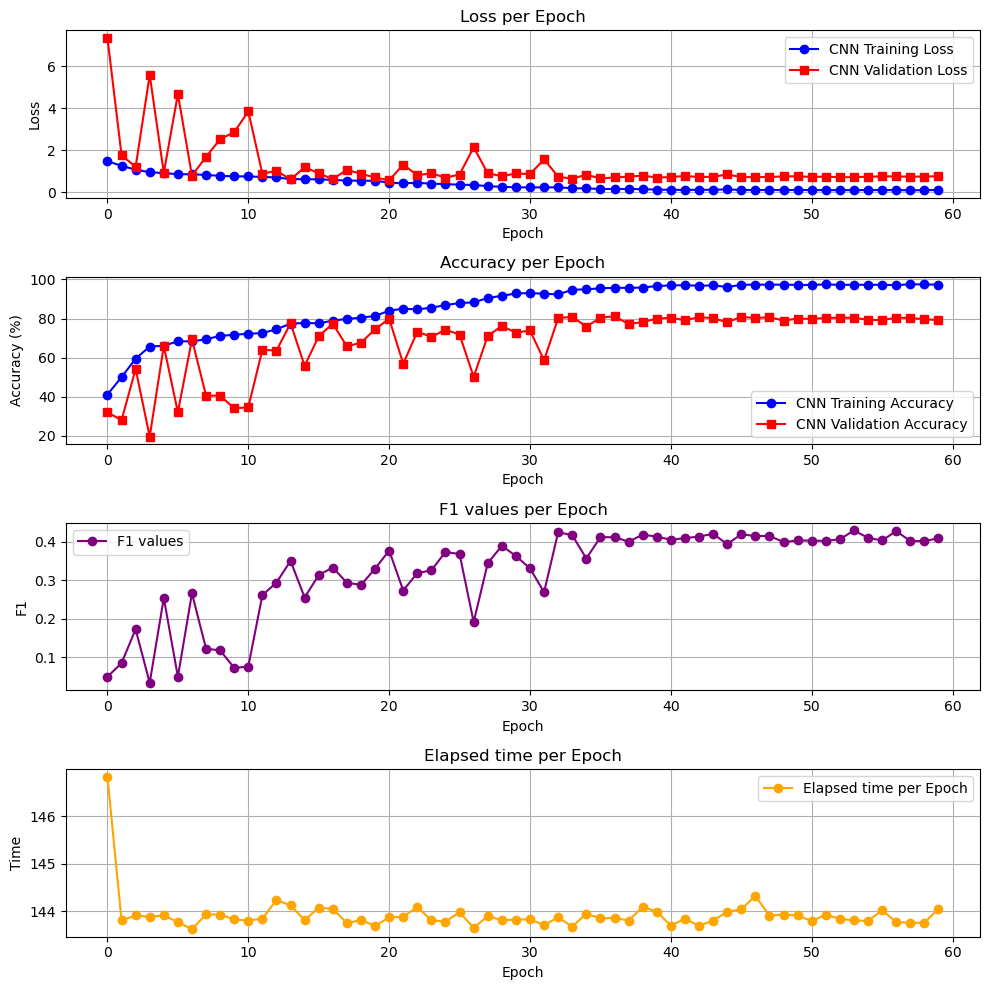

In [21]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(4, 1,1)
plt.plot(cnn_train_loss_history, marker='o', label='CNN Training Loss', color='blue')
plt.plot(cnn_val_loss_history,marker='s', label='CNN Validation Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(4, 1, 2)
plt.plot(cnn_train_acc_history, marker= 'o', label='CNN Training Accuracy', color= 'blue')
plt.plot(cnn_val_acc_history,marker= 's', label= 'CNN Validation Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.subplot(4, 1, 3)
plt.plot(cnn_val_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid(True)
plt.legend()


plt.subplot(4, 1, 4)
plt.plot(cnn_epoch_time, marker= 'o', label='Elapsed time per Epoch', color= 'orange')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Elapsed time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.savefig('protein_voxel_3Dcnn_10000Samples_10Classes.png')
plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_voxel_3d(grid, threshold=0.3, max_points=5000, title="Voxel grid"):
    """
    grid: np.array of shape (G,G,G) or (1,G,G,G)
    threshold: only show voxels with value >= threshold
    max_points: random subsample for speed
    """
    if grid.ndim == 4:  # (C,G,G,G) or (1,G,G,G)
        grid = grid[0]  # take first channel

    assert grid.ndim == 3
    G = grid.shape[0]

    xs, ys, zs = np.where(grid >= threshold)
    vals = grid[xs, ys, zs]

    if len(xs) == 0:
        print("No voxels above threshold.")
        return

    # Subsample if too many points
    if len(xs) > max_points:
        idx = np.random.choice(len(xs), size=max_points, replace=False)
        xs, ys, zs, vals = xs[idx], ys[idx], zs[idx], vals[idx]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    p = ax.scatter(xs, ys, zs, c=vals, s=5, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.colorbar(p, ax=ax, label="Intensity")
    plt.tight_layout()
    plt.show()


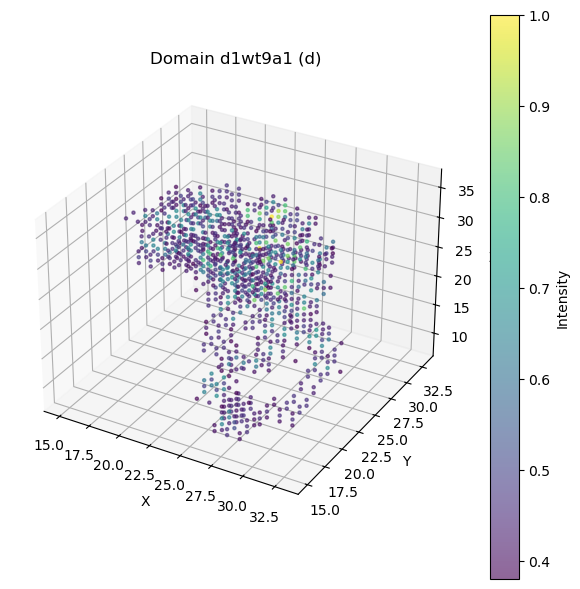

In [24]:
# pick a random row from train_df (or df_coarse)
row = train_df.sample(1).iloc[0]
coords = row["ca_coords"]
grid = voxelize_ca(coords, grid_size=48)  # np.array (48,48,48)

plot_voxel_3d(grid, threshold=0.3, title=f"Domain {row['domain']} ({row['main_class']})")

In [25]:
from sklearn.metrics import confusion_matrix

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model, test_loader, device)
cm = confusion_matrix(labels, preds)
print(cm)

/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[[180   0   1  15   0   1   1   0   0   0]
 [  0 300   3  19   0   0   2   0   0   0]
 [  5   8 138  75   1   0   0   0   0   0]
 [  9  17  21 174   1   0   6   0   0   0]
 [  1   1   3   2   2   0   0   0   0   0]
 [  6   0   0   0   0   1   0   0   0   0]
 [  2   0   0   2   0   0   6   0   0   0]
 [  0   0   0   0   1   2   0   0   0   0]
 [  0   0   3   0   0   1   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0]]


<Figure size 640x480 with 0 Axes>

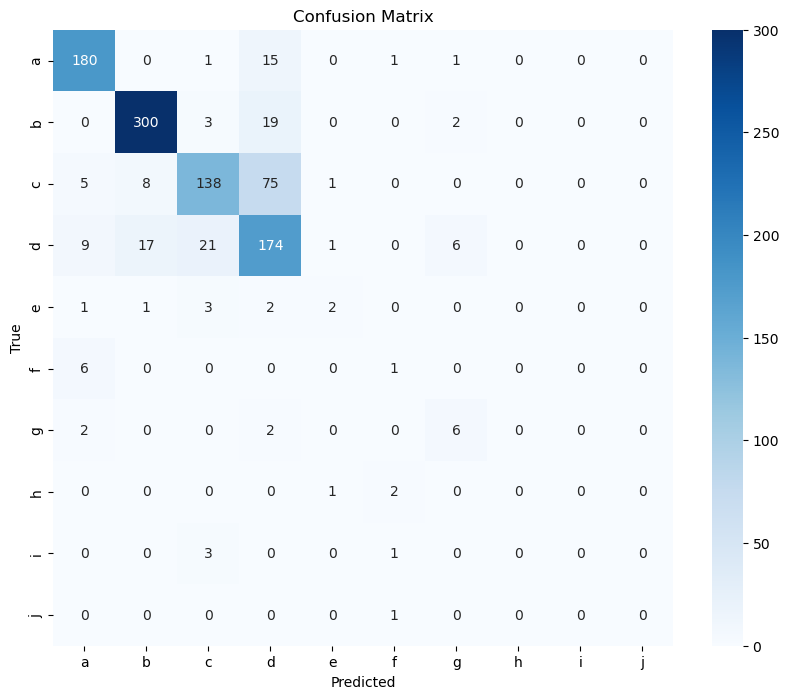

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["a", "b", "c", "d","e","f","g","h","i","j"]   
plt.savefig('protein_voxel_CNN_10Classes_ConfusionMatrix.png')
plot_confusion_matrix(cm, class_names)

In [19]:
import pennylane as qml
import os
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.func import vmap

In [20]:
#AutoEncoder Class

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=12):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(3*192*192, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(f"Input:{x.shape}")
        x = torch.flatten(x, start_dim=1)
        #print(f"After conv1: {x.shape}")
        x = F.relu(self.linear1(x))
        #print(f"After conv2: {x.shape}")
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        #print(f"Output (Latent): {x.shape}")
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4, 512)
        self.fc2 = nn.Linear(512, 64 * 16 * 16)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        #print(f"Input (Latent): {x.shape}")
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #print(f"After fc2: {x.shape}")
        x = x.view(-1, 64, 16, 16)
        #print(f"After view: {x.shape}")
        x = torch.relu(self.deconv1(x))
        #print(f"After deconv1: {x.shape}")
        x = torch.relu(self.deconv2(x))
        #print(f"After deconv2: {x.shape}")
        x = torch.sigmoid(self.deconv3(x))
        #print(f"Output (Reconstruction): {x.shape}")
        return x


In [27]:
dev = qml.device("default.qubit", wires=12)

In [38]:
# QCNN layer
def qcnn_block(weights,wires):
    
    for w in range(wires):
        qml.Hadamard(w)
    
    #qml.Toffoli(wires=(0,1,2))
    # Convolution Layer 1
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[0], wires=1)
    qml.CNOT(wires=[2, 3])
    qml.RZ(weights[1], wires=3)
    qml.CNOT(wires=[4, 5])
    qml.RZ(weights[3], wires=5)
    qml.CNOT(wires=[6, 7])
    qml.RZ(weights[5], wires=7)
    qml.CNOT(wires=[8, 9])
    qml.RZ(weights[7], wires=9)
    qml.CNOT(wires=[10, 11])
    qml.RZ(weights[9], wires=11)
    #qml.CNOT(wires=[8, 9])
    #qml.RY(weights[7], wires=9)
    #qml.CNOT(wires=[8, 9])
    #qml.RY(weights[7], wires=9)
    
    # Pooling Layer 1
    qml.CNOT(wires=[1, 0])
    qml.RY(weights[2], wires=0)  # keep 0, discard 1
    qml.CNOT(wires=[3, 2])
    qml.RY(weights[4], wires=2)  # keep 2, discard 3
    qml.CNOT(wires=[5, 4])
    qml.RY(weights[6], wires=4)  # keep 4, discard 5
    qml.CNOT(wires=[7, 6])
    qml.RY(weights[8], wires=6)  # keep 6, discard 7
    qml.CNOT(wires=[9, 8])
    qml.RY(weights[10], wires=8)  # keep 8, discard 9
    qml.CNOT(wires=[11, 10])
    qml.RY(weights[12], wires=10)  # keep 10, discard 11

    
    # Convolution Layer 2
    qml.CNOT(wires=[1, 5])
    qml.RZ(weights[11], wires=5)
    qml.CNOT(wires=[3, 9])
    qml.RZ(weights[13], wires=9)
    qml.CNOT(wires=[7, 11])
    qml.RZ(weights[14], wires=11)
    #qml.CNOT(wires=[6, 8])
    #qml.RY(weights[11], wires=8)

    # Pooling Layer 2
    qml.CNOT(wires=[3, 1])
    qml.RY(weights[8], wires=3)  # keep 3, discard 1
    qml.CNOT(wires=[7, 5])
    qml.RY(weights[10], wires=7)  # keep 7, discard 5
    qml.CNOT(wires=[11, 9])
    qml.RY(weights[12], wires=11)  # keep 11, discard 9
    #qml.CNOT(wires=[7, 6])
    #qml.RY(weights[8], wires=6)  # keep 6, discard 7
    #qml.CNOT(wires=[9, 8])
    #qml.RY(weights[10], wires=8)  # keep 8, discard 9
    

# Convolution Layer 3 (Final Layer)
    qml.CNOT(wires=[7, 2])
    qml.RZ(weights[13], wires=7)
    qml.CNOT(wires=[9, 4])
    qml.RZ(weights[14], wires=11)


In [39]:
# Full QCNN circuit

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle encoding
    qml.templates.AngleEmbedding(inputs, wires=range(12), rotation='Y')
    qcnn_block(weights,wires=12)
    #print(qml.draw(qcnn_block)(weights))
    return [qml.expval(qml.PauliZ(i)) for i in [0,3,6,9,11]]

In [24]:
weight_shapes = {"weights": (16,)}
qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)

#QCNN and AutoEncoder Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dims=12)
        self.quantum = qcnn_layer
        self.decoder = Decoder()
        self.fc_out = nn.Linear(4, 10)  # Output logits for 10 fold classes

    
    def forward(self, x):
        latent = self.encoder(x)                      # Compress image to latent space
        #print(f"--- Hybrid Pass ---")
        #print(f"Latent Output to Quantum: {latent.shape}")
        quantum_out = self.quantum(latent)            # Quantum processing
        #print(f"Quantum Output to Decoder: {quantum_out.shape}")
        recons_image = self.decoder(quantum_out)      # reconstruction of image
        class_logits = self.fc_out(quantum_out)   # Final classification layer
        #print(f"Classifier Logits: {class_logits.shape}")                
        return recons_image, F.log_softmax(class_logits, dim=1)

In [40]:

weight_shapes = {"weights": (16,)}
#qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)
        #outputs = [self.qlayer(sample) for sample in x]
        #return torch.stack(outputs)
        """
        outputs = []
        for i, sample in enumerate(x):
            out = self.qlayer(sample)
            outputs.append(out)
        stacked = torch.stack(outputs)
        #print("  Inside QuantumLayer: input", x.shape, "output", stacked.shape)
        return stacked
        """
#QCNN Model Class
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*192*192,12) #C x H x W
        self.qcnn = QuantumLayer()
        #self.qcnn = qcnn_layer
        self.fc2 = nn.Linear(in_features=5, out_features=32)
        self.fc3 = nn.Linear(32, 16)       
        self.fc4 = nn.Linear(16, 10)   # Output layer for 10 classes
    @staticmethod
    def check_for_nans(x):
        if torch.isnan(x).any():
            print("NaNs detected!")
        if torch.isinf(x).any():
            print("Infs detected!")
    
    def forward(self, x):
        x = x.view(x.size(0), -1 )
        #print("Input shape before fc1:", x.shape)
        x = torch.tanh(self.fc1(x))
        #print("Shape after fc1:", x.shape)
        self.check_for_nans(x)
        x = self.qcnn(x) # [batch_size, 2]
        x = F.relu(self.fc2(x))
        #print("Shape after fc2:", x.shape)
        self.check_for_nans(x)
        x = F.relu(self.fc3(x))
        #print("Shape after fc2:", x.shape)
        self.check_for_nans(x)
        x = self.fc4(x)
        #print("Shape after fc3:", x.shape)
        self.check_for_nans(x)
        #return F.log_softmax(x, dim=1)
        return x

In [41]:
#Validation Function
def qcnn_eval(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            #reconstruction, outputs = model(features)
            outputs = model(features)
            
            # Loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall    = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1        = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1

"""
def qcnn_val(model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            reconstructed_image, classification_logits = model(features)
            # Use only the classification_logits for the loss calculation
            loss = criterion(classification_logits, labels)
            #outputs = model(features)
            
            # Calculate and accumulate loss
            #loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(classification_logits.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(test_loader)
        accuracy = correct / len(test_loader.dataset)
        
    # Calculate macro-averaged metrics
    # Note: Scikit-learn requires non-empty lists, which is guaranteed here
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1
"""
# --- Training Loop ---


"\ndef qcnn_val(model, criterion, device):\n    model.eval()\n    running_loss = 0.0\n    correct = 0\n    \n    all_labels = []\n    all_predictions = []\n    \n    with torch.no_grad():\n        for features, labels in test_loader:\n            features, labels = features.to(device), labels.to(device)\n            reconstructed_image, classification_logits = model(features)\n            # Use only the classification_logits for the loss calculation\n            loss = criterion(classification_logits, labels)\n            #outputs = model(features)\n            \n            # Calculate and accumulate loss\n            #loss = criterion(outputs, labels)\n            running_loss += loss.item()\n            \n            _, predicted = torch.max(classification_logits.data, 1)\n            correct += (predicted == labels).sum().item()\n\n            all_labels.extend(labels.cpu().numpy())\n            all_predictions.extend(predicted.cpu().numpy())\n            \n        avg_loss = runni

In [42]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = HybridModel().to(device)
model = QCNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


# History lists for plotting

qcnn_train_loss_history = []
qcnn_train_acc_history = []
qcnn_val_loss_history = []
qcnn_val_acc_history = []
qcnn_val_f1_history = [] 
qcnn_epoch_time = []
"""
qcnnVAE_train_loss_history = []
qcnnVAE_train_acc_history = []
qcnnVAE_val_loss_history = []
qcnnVAE_val_acc_history = []
qcnnVAE_val_f1_history = [] 
qcnnVAE_epoch_time = []
"""
loss_bench = 0
n_epochs = 50

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



# --- Training Loop ---

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        #labels = labels.long()

        # Double check after conversion
        
        #print("Labels dtype:", labels.dtype)  # Should print torch.int64
        #print("Labels range:", labels.min(), labels.max())  # Should be between [0, 3] for a 4-class problem
        #assert labels.min() >= 0 and labels.max() < 4, "Labels are out of range!"  # Check for out-of-range labels
        optimizer.zero_grad()
        #reconstruction, outputs = model(features)
        outputs = model(features)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Training metrics
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    
    # Validation step
    val_loss, val_acc, val_prec, val_rec, val_f1 = qcnn_eval(
        model, criterion, test_loader, device
    )
    
    scheduler.step(val_loss)

       
    # Store metrics
    qcnn_train_loss_history.append(train_loss)
    qcnn_train_acc_history.append(train_acc * 100)
    qcnn_val_loss_history.append(val_loss)
    qcnn_val_acc_history.append(val_acc * 100)
    qcnn_val_f1_history.append(val_f1)
    qcnn_epoch_time.append(end_time - start_time)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f} | "
          f"Time: {end_time - start_time:.2f}s")

print(f"Parameter Count: {count_parameters(model)}|")
"""
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader:
        
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        reconstructed_image, classification_logits = model(features)
        # Use only the classification_logits for the loss calculation
        loss = criterion(classification_logits, labels)
        #outputs = model(features)
        #loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(classification_logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = correct /len(train_loader.dataset)
    
    # Store Training History
    train_loss_history.append(train_avg_loss)
    train_acc_history.append(train_accuracy*100)
    
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = qcnn_eval(model, criterion, device,)

    scheduler.step(val_loss)
    
    # Store Test History
    test_loss_history.append(val_loss)
    test_acc_history.append(val_accuracy*100)
    test_f1_history.append(val_f1) # Example of tracking
    
    
    epoch_duration = end_time - start_time
    
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")
print(f"Parameter Count: {count_parameters(model)}|")
"""

Epoch 01: Train Loss: 1.9243, Train Acc: 0.2645 | Val Loss: 1.6117, Val Acc: 0.3180 | Precision: 0.0318, Recall: 0.1000, F1: 0.0483 | Time: 58.21s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 02: Train Loss: 1.5404, Train Acc: 0.3181 | Val Loss: 1.5124, Val Acc: 0.3185 | Precision: 0.0501, Recall: 0.1003, F1: 0.0492 | Time: 57.47s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 03: Train Loss: 1.4923, Train Acc: 0.3179 | Val Loss: 1.4917, Val Acc: 0.3185 | Precision: 0.0403, Recall: 0.1002, F1: 0.0489 | Time: 57.64s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 04: Train Loss: 1.4692, Train Acc: 0.3181 | Val Loss: 1.4852, Val Acc: 0.3194 | Precision: 0.1069, Recall: 0.1113, F1: 0.0670 | Time: 55.63s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 05: Train Loss: 1.4498, Train Acc: 0.3218 | Val Loss: 1.4728, Val Acc: 0.3185 | Precision: 0.0604, Recall: 0.1110, F1: 0.0643 | Time: 55.98s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 06: Train Loss: 1.4237, Train Acc: 0.3226 | Val Loss: 1.4483, Val Acc: 0.3190 | Precision: 0.0654, Recall: 0.1112, F1: 0.0611 | Time: 56.21s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 07: Train Loss: 1.3757, Train Acc: 0.3879 | Val Loss: 1.4040, Val Acc: 0.4445 | Precision: 0.1262, Recall: 0.1742, F1: 0.1332 | Time: 55.92s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 08: Train Loss: 1.3107, Train Acc: 0.4730 | Val Loss: 1.3619, Val Acc: 0.4562 | Precision: 0.1419, Recall: 0.1802, F1: 0.1345 | Time: 59.90s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 09: Train Loss: 1.2455, Train Acc: 0.4871 | Val Loss: 1.3405, Val Acc: 0.4670 | Precision: 0.1686, Recall: 0.1907, F1: 0.1478 | Time: 56.29s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Train Loss: 1.1906, Train Acc: 0.5026 | Val Loss: 1.3367, Val Acc: 0.4632 | Precision: 0.1871, Recall: 0.1886, F1: 0.1472 | Time: 57.55s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Train Loss: 1.1380, Train Acc: 0.5225 | Val Loss: 1.3216, Val Acc: 0.4801 | Precision: 0.2102, Recall: 0.1978, F1: 0.1653 | Time: 57.43s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Train Loss: 1.0858, Train Acc: 0.5489 | Val Loss: 1.3346, Val Acc: 0.4834 | Precision: 0.2199, Recall: 0.1988, F1: 0.1752 | Time: 56.04s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Train Loss: 1.0347, Train Acc: 0.5740 | Val Loss: 1.3233, Val Acc: 0.4899 | Precision: 0.2098, Recall: 0.2038, F1: 0.1866 | Time: 55.57s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Train Loss: 0.9837, Train Acc: 0.6098 | Val Loss: 1.3431, Val Acc: 0.5021 | Precision: 0.2643, Recall: 0.2139, F1: 0.2093 | Time: 62.06s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Train Loss: 0.9302, Train Acc: 0.6369 | Val Loss: 1.3657, Val Acc: 0.5044 | Precision: 0.2408, Recall: 0.2097, F1: 0.2042 | Time: 59.15s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Train Loss: 0.8765, Train Acc: 0.6676 | Val Loss: 1.3894, Val Acc: 0.5208 | Precision: 0.2629, Recall: 0.2148, F1: 0.2116 | Time: 54.45s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Train Loss: 0.8294, Train Acc: 0.6926 | Val Loss: 1.4444, Val Acc: 0.5180 | Precision: 0.3198, Recall: 0.2124, F1: 0.2111 | Time: 55.41s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Train Loss: 0.7802, Train Acc: 0.7181 | Val Loss: 1.4680, Val Acc: 0.5302 | Precision: 0.2271, Recall: 0.2152, F1: 0.2141 | Time: 54.55s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Train Loss: 0.7333, Train Acc: 0.7423 | Val Loss: 1.5233, Val Acc: 0.5377 | Precision: 0.3274, Recall: 0.2233, F1: 0.2267 | Time: 57.15s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Train Loss: 0.6908, Train Acc: 0.7645 | Val Loss: 1.6429, Val Acc: 0.5222 | Precision: 0.2827, Recall: 0.2162, F1: 0.2219 | Time: 57.96s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Train Loss: 0.6477, Train Acc: 0.7841 | Val Loss: 1.7166, Val Acc: 0.5340 | Precision: 0.3268, Recall: 0.2298, F1: 0.2396 | Time: 62.40s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Train Loss: 0.6100, Train Acc: 0.7984 | Val Loss: 1.6821, Val Acc: 0.5443 | Precision: 0.2979, Recall: 0.2282, F1: 0.2358 | Time: 55.98s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Train Loss: 0.5583, Train Acc: 0.8222 | Val Loss: 1.7521, Val Acc: 0.5452 | Precision: 0.3036, Recall: 0.2341, F1: 0.2438 | Time: 55.65s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Train Loss: 0.5255, Train Acc: 0.8403 | Val Loss: 1.8181, Val Acc: 0.5518 | Precision: 0.3071, Recall: 0.2376, F1: 0.2475 | Time: 60.95s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Train Loss: 0.5052, Train Acc: 0.8507 | Val Loss: 1.8491, Val Acc: 0.5485 | Precision: 0.3178, Recall: 0.2417, F1: 0.2547 | Time: 57.48s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Train Loss: 0.4849, Train Acc: 0.8557 | Val Loss: 1.8760, Val Acc: 0.5546 | Precision: 0.3171, Recall: 0.2448, F1: 0.2573 | Time: 57.39s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Train Loss: 0.4668, Train Acc: 0.8615 | Val Loss: 1.9197, Val Acc: 0.5536 | Precision: 0.3199, Recall: 0.2444, F1: 0.2575 | Time: 57.96s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Train Loss: 0.4493, Train Acc: 0.8683 | Val Loss: 2.0139, Val Acc: 0.5461 | Precision: 0.3038, Recall: 0.2419, F1: 0.2539 | Time: 57.67s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Train Loss: 0.4330, Train Acc: 0.8728 | Val Loss: 2.0780, Val Acc: 0.5489 | Precision: 0.3199, Recall: 0.2409, F1: 0.2539 | Time: 59.29s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Train Loss: 0.4160, Train Acc: 0.8770 | Val Loss: 2.1554, Val Acc: 0.5489 | Precision: 0.3155, Recall: 0.2408, F1: 0.2534 | Time: 56.42s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Train Loss: 0.3998, Train Acc: 0.8841 | Val Loss: 2.1359, Val Acc: 0.5560 | Precision: 0.3200, Recall: 0.2454, F1: 0.2584 | Time: 58.51s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Train Loss: 0.3837, Train Acc: 0.8890 | Val Loss: 2.2361, Val Acc: 0.5546 | Precision: 0.3058, Recall: 0.2494, F1: 0.2621 | Time: 57.01s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Train Loss: 0.3707, Train Acc: 0.8931 | Val Loss: 2.2753, Val Acc: 0.5555 | Precision: 0.3007, Recall: 0.2447, F1: 0.2559 | Time: 56.92s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Train Loss: 0.3475, Train Acc: 0.9020 | Val Loss: 2.3229, Val Acc: 0.5536 | Precision: 0.3102, Recall: 0.2498, F1: 0.2633 | Time: 59.68s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

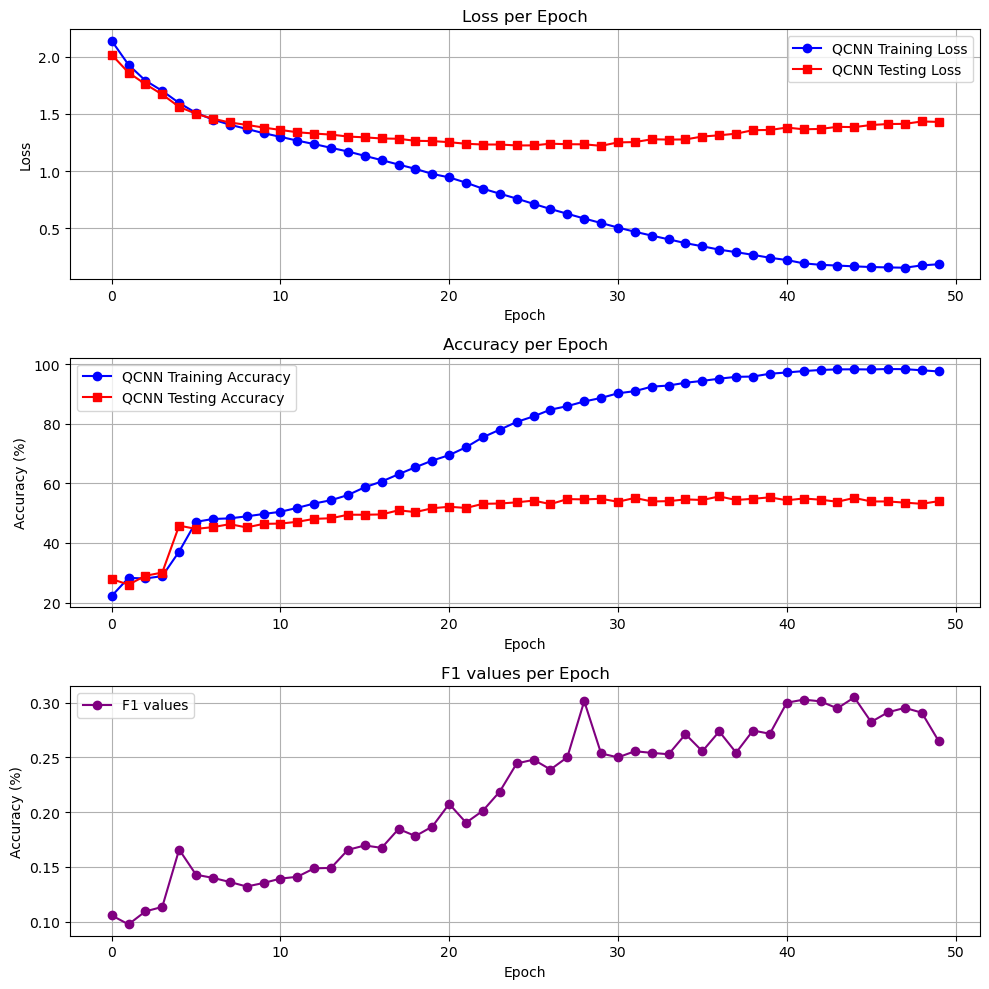

In [45]:
import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(3, 1,1)
plt.plot(qcnnVAE_train_loss_history, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(qcnnVAE_val_loss_history,marker='s', label='QCNN Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(3, 1, 2)
plt.plot(qcnnVAE_train_acc_history, marker= 'o', label='QCNN Training Accuracy', color= 'blue')
plt.plot(qcnnVAE_val_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(qcnnVAE_val_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.tight_layout()
#plt.savefig('protein_qcnnVAE_2D_5000_8Qubits.png')
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

labels, preds = get_predictions(model, test_loader, device)
cm = confusion_matrix(labels, preds)
print(cm)

/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TypeError: max() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)


<Figure size 640x480 with 0 Axes>

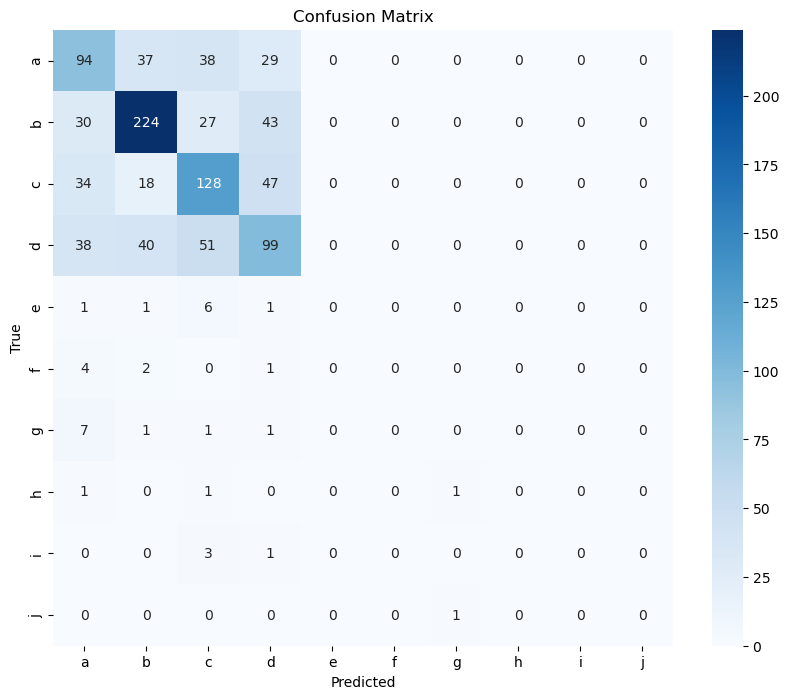

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["a", "b", "c", "d","e","f","g","h","i","j"]   
plt.savefig('protein_voxel_QCNN_10Classes_ConfusionMatrix.png')
plot_confusion_matrix(cm, class_names)